In [79]:
### Load keypoints detection model
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model = keypointrcnn_resnet50_fpn(weights=weights)
transforms = weights.transforms()
model.eval().to("cpu")


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [80]:
### Import Videos

import av
from torchvision.io import read_video
import os

video_path = os.path.join("Nov24", "walking.mp4")
video, audio, meta = read_video(video_path, pts_unit="sec", output_format="TCHW")
print(meta, len(video))

{'video_fps': 29.88291588955274, 'audio_fps': 44100} 162


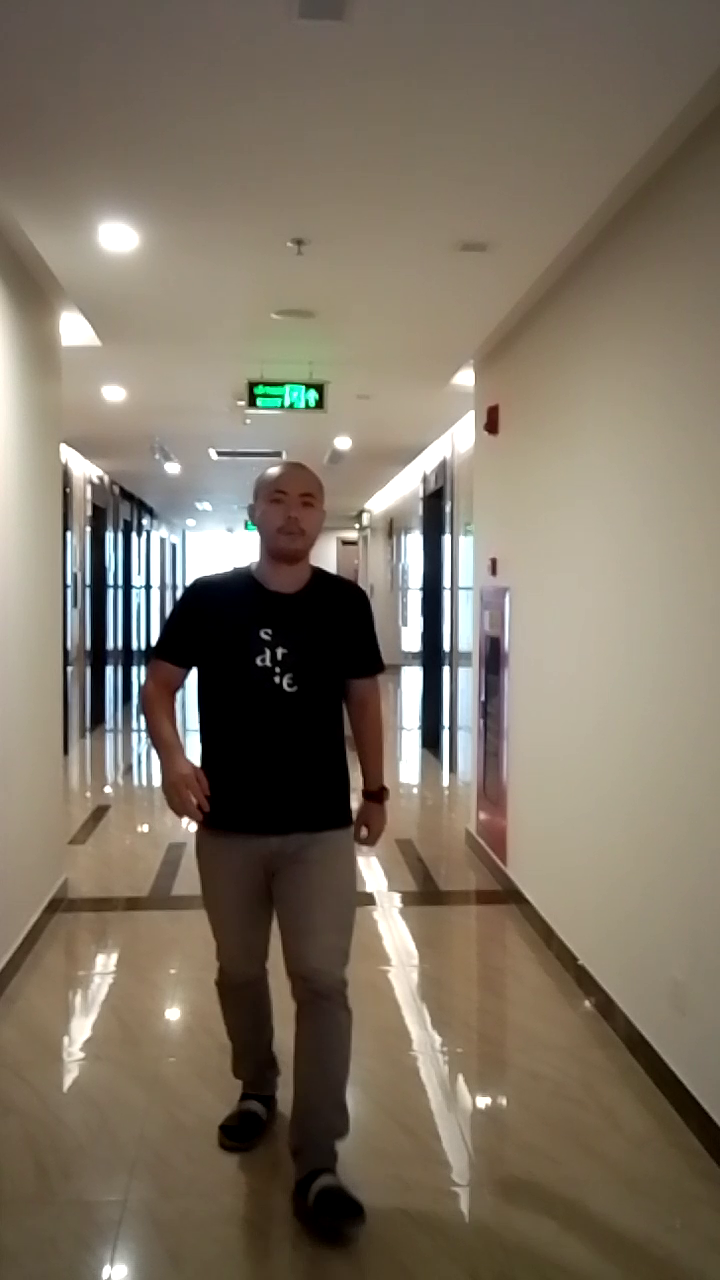

In [87]:
### Display one frame from the video
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

frame = to_pil_image(video[150])
frame = frame.rotate(90, expand=True)
frame

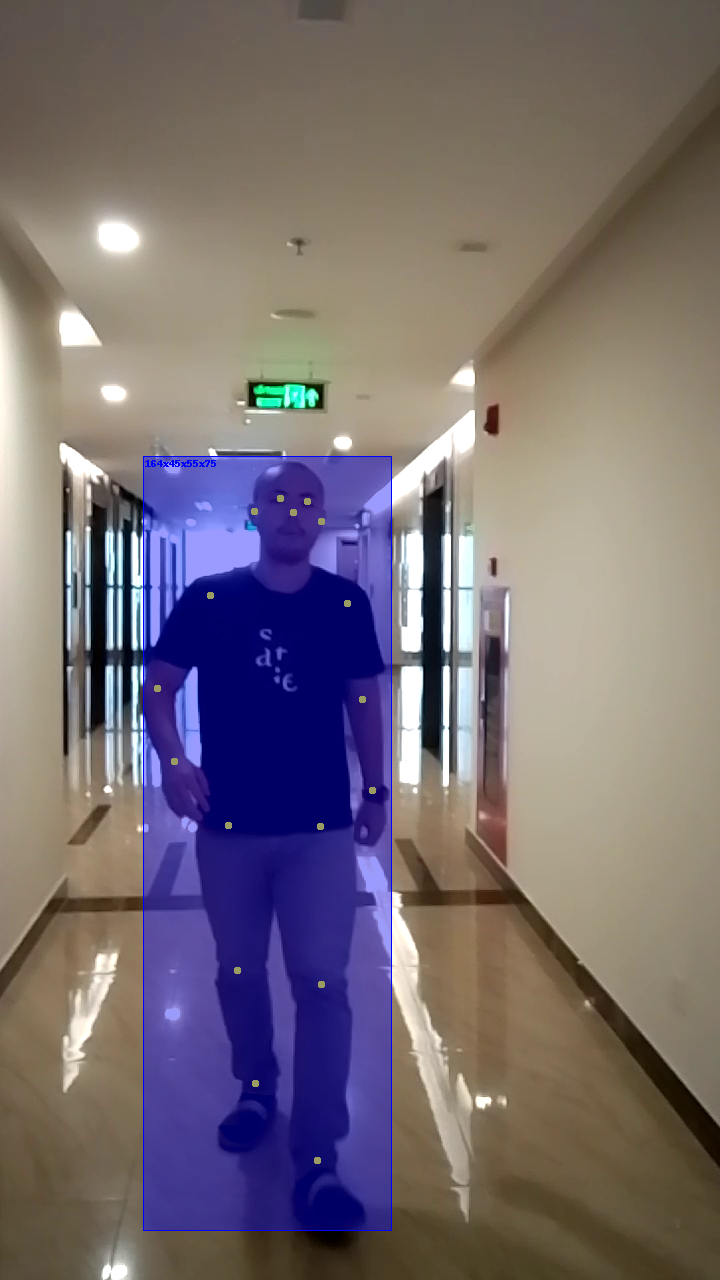

In [88]:
### Function to Make Keypoint Detection on Frame
import torch
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from torchvision.utils import draw_keypoints, draw_bounding_boxes

def detect(frame):
    
    ### Make Predictions on Frame
    body_matrix = transforms(frame)
    predictions = model([body_matrix.to("cpu")])
    
    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    keypoints = predictions[0]['keypoints']
    
    ### Filter for the main Bounding Box and Keypoints
    top = torch.max(scores)
    idx = torch.where(scores == top)
    
    kp = torch.unsqueeze(keypoints[idx][0], dim=0)
    bx = torch.unsqueeze(boxes[idx][0], dim=0)
    
    ### Draw Keypoints and Bounding Boxes
    tensor_image = pil_to_tensor(frame)
    keypoints_image = draw_keypoints(tensor_image, kp, colors="yellow", radius=3)
    final_image = draw_bounding_boxes(keypoints_image, bx, labels=['164x45x55x75'], colors="blue", fill=True)
    
    return to_pil_image(final_image)
    
final_image = detect(frame)
final_image

In [89]:
### Run Detections on all Frames and generate new Video
import av
import math
import numpy as np

### Create an empty mp4 video container
container = av.open("measurements.mp4", mode="w")
video_fps = math.ceil(meta['video_fps'])

### Create a data stream to encode image frame into mp4 container
stream = container.add_stream("mpeg4", rate=video_fps)
stream.width = frame.width
stream.height = frame.height

frame_count = len(video)

for idx in range(frame_count):
    print(f"Processing frame {idx+1} of {frame_count}", end='\r')
    frame = video[idx]
    image = to_pil_image(frame)
    image = image.rotate(90, expand=True)

    def encode(image):
        frame = av.VideoFrame.from_image(image)

        ### Turn each frame into data packet and fill in the contrainer
        for packet in stream.encode(frame):
            container.mux(packet)

    if idx %6 == 0:
        predicted_image = detect(image)
        encode(predicted_image)     
    else:
        encode(image)

container.close()